# Local Map Algebra



In [1]:
from IPython.core.display import display
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes.rasterfunctions import rf_normalized_difference, rf_tile, rf_dimensions, rf_extent, rf_tile_mean
import pyrasterframes.rf_ipython

import pandas as pd
import os

spark = create_rf_spark_session()


[Local map algebra](https://gisgeography.com/map-algebra-global-zonal-focal-local/) raster operations are element-wise operations on a single _tile_,  between a _tile_ and a scalar, between two _tiles_, or among many _tiles_. These operations are common in processing of earth observation imagery and other image data.

<img src="https://gisgeography.com/wp-content/uploads/2015/05/Local-Operation-Raster.png" alt="local op" style="width:200px;"/>

Credit: [GISGeography](https://gisgeography.com)


## Computing NDVI

Here is an example of computing the Normalized Differential Vegetation Index (NDVI). NDVI is a vegetation index which emphasizes differences in relative biomass and vegetation health. The term _index_ in Earth observation means a combination of many raster bands into a single band that highlights a phenomenon of interest. Various indices have proven useful visual tools and frequently appear as features in machine learning models using Earth observation data.

> NDVI is often used worldwide to monitor drought, monitor and predict agricultural production, assist in predicting hazardous fire zones, and map desert encroachment. The NDVI is preferred for global vegetation monitoring because it helps to compensate for changing illumination conditions, surface slope, aspect, and other extraneous factors (Lillesand. _Remote sensing and image interpretation_. 2004)

We will apply the @ref:[catalog pattern](raster-catalogs.md) for defining the data we wish to process. To compute NDVI we need to compute local algebra on the *red* and *near infrared* (nir) bands: 

           nir - red
    NDVI = ---------
           nir + red

This form of `(x - y) / (x + y)` is common in remote sensing and is called a normalized difference. It is used with other band pairs to highlight water, snow, and other phenomena.



In [2]:
from pyspark.sql import Row
uri_pattern = 'https://s22s-test-geotiffs.s3.amazonaws.com/luray_snp/B0{}.tif'
catalog_df = spark.createDataFrame([
    Row(red=uri_pattern.format(4), nir=uri_pattern.format(8))
])
df = spark.read.raster(
    catalog_df,
    catalog_col_names=['red', 'nir']
)
df.printSchema()

root
 |-- red_path: string (nullable = false)
 |-- nir_path: string (nullable = false)
 |-- red: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)
 |-- nir: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nulla


Observe how the bands we need to use to compute the index are arranged as columns of our resulting DataFrame. The rows or observations are various spatial extents within the entire coverage area.

RasterFrames provides a wide variety of local map algebra functions. There are several different broad categories, based on how many _tiles_ the function takes as input:

 * A function on a single _tile_ is a unary operation; example: @ref:[rf_log](reference.md#rf-log);
 * A function on two _tiles_ is a binary operation; example: @ref:[rf_local_multiply](reference.md#rf-local-multiply);
 * A function on a _tile_ and a scalar is a binary operation; example: @ref:[rf_local_less](reference.md#rf-local-less); or
 * A function on many _tiles_ is a n-ary operation; example: @ref:[rf_agg_local_min](reference.md#rf-agg-local-min)

We can express the normalized difference with a combination of `rf_local_divide`, `rf_local_subtract`, and `rf_local_add`. Since the normalized difference is so common, there is a convenience method `rf_normalized_difference`, which we use in this example. We will append a new column to the DataFrame, which will apply the map alegbra function to each row.



In [3]:
df = df.withColumn('ndvi', rf_normalized_difference(df.nir, df.red))
df.printSchema()

root
 |-- red_path: string (nullable = false)
 |-- nir_path: string (nullable = false)
 |-- red: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)
 |-- nir: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nulla


We can inspect a sample of the data. Yellow indicates very healthy vegetation, and purple represents bare soil or impervious surfaces.



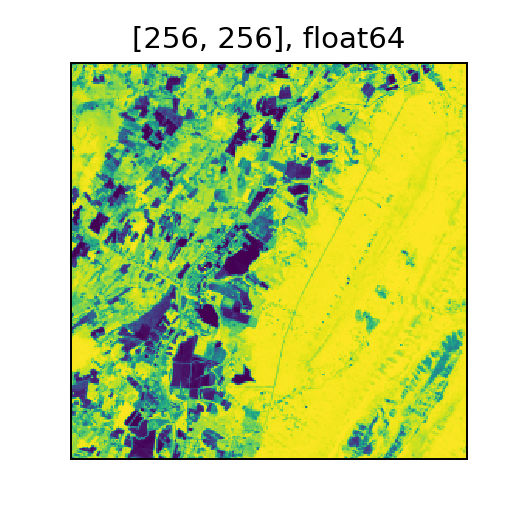

In [4]:
t = df.select(rf_tile('ndvi').alias('ndvi')).first()['ndvi']
display(t)


We continue examining NDVI in the @ref:[time series](time-series.md) section.
